In [1]:
#core
import sys
import pandas as pd
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.metrics import recall_score
import pickle
from shapash import SmartExplainer

#geo
import geopandas as gpd
import h3pandas
from shapely.geometry import Polygon, Point, LineString, shape
from keplergl import KeplerGl

from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier

sys.path.append('../src')

import utils as gt
from enums import postgress_connection, postgress_db, lp, schema, RES, bad_hex_with_postamat

# some initial values
engine = create_engine(f'postgresql://{lp}@{postgress_connection}/{postgress_db}')

PATH = '../data'
RANDOM_STATE = 42

SCHEMA = schema

## Сбор данных для модели

In [2]:
df_feats = pd.read_sql(f"select * from {SCHEMA}.platform_features", engine)
df_feats10 = df_feats[df_feats['kind'] == 'walking_10min']

In [3]:
df_domain = pd.read_sql(f"select * from {SCHEMA}.platform_domain", engine)

In [4]:
df_postamats = pd.read_sql(f"""
with hex_mall as 
( 
select distinct geo_h3_10
from postamat.platform_companies pc 
where rubric in ('Торговые центры / Универсальные магазины', 
                 'Торгово-развлекательные центры / Моллы', 
                 'Торговые центры товаров для интерьера / ремонта')
)
select pc.*
from postamat.platform_companies pc
left join hex_mall hm
    on pc.geo_h3_10 = hm.geo_h3_10
where rubric = 'Постаматы' 
    and hm.geo_h3_10 is null
    and rubrics_0_name = 'Постаматы'
""", engine)
df_postamats['company'] = df_postamats['name'].str.split(',').str[0]

In [5]:
df_passability = pd.read_sql(f"""SELECT geo_h3_10, cnt_morning, cnt_afternoon, cnt_evening, cnt_night
FROM {SCHEMA}.msk_pass""", engine)

In [6]:
df_domain.head()

,geo_h3_10,adm_name,okrug_name,geometry
0,8a11aa612c47fff,Перово,Восточный административный округ,0103000020E610000001000000070000001CE84C0D33E2...
1,8a11aa6a5b77fff,Перово,Восточный административный округ,0103000020E610000001000000070000007B6A5610DEDF...
2,8a11aa6a5aaffff,Перово,Восточный административный округ,0103000020E610000001000000070000000D5A3E6193E0...
3,8a11aa612937fff,Перово,Восточный административный округ,0103000020E610000001000000070000004FE99CABD0E0...
4,8a11aa6121a7fff,Перово,Восточный административный округ,0103000020E61000000100000007000000D0523442A2E2...


## Сбор таргета - первая версия

In [7]:
# Версия таргета - постаматы в локациях, где их минимум несколько
tgt_1 = df_postamats[[f'geo_h3_{RES}',
                      'name', 'point_lat', 'point_lon']].copy()
tgt_1 = tgt_1.groupby([f'geo_h3_{RES}'])['name'].count(
).reset_index().sort_values(by=['name'], ascending=False)

In [8]:
tgt_1['target'] = 1
tgt_1['desc'] = 'many'
tgt_1.loc[tgt_1['name']==1, 'desc'] = 'only_one_postmat'
tgt_1.rename(columns = {'name': 'cnt'}, inplace=True)

In [ ]:
# // industrial.geojson
# [out:json][bbox:{{bbox}}];
# (
#   way["landuse"="industrial"]({{bbox}});
#   relation["landuse"="industrial"]({{bbox}});
# );
# out geom;
# >;

In [9]:
bad_polygons = gpd.read_file(f'{PATH}/industrial.geojson')
bad_polygons = bad_polygons[bad_polygons['geometry'].apply(lambda x: type(x) not in [Point, LineString])]
bad_polygons = bad_polygons.h3.polyfill_resample(RES).reset_index()
bad_polygons.rename(columns = {'h3_polyfill': f'geo_h3_{RES}'}, inplace=True)
bad_polygons = bad_polygons[bad_polygons[f'geo_h3_{RES}'].isin(
    df_domain[f'geo_h3_{RES}'])].drop_duplicates(subset=f'geo_h3_{RES}')

/Users/mariastepanova/opt/anaconda3/envs/ltc22/lib/python3.8/site-packages/h3pandas/h3pandas.py:751: UserWarning:

1356 rows did not generate a H3 cell.Consider using a finer resolution.



In [10]:
tgt_00 = bad_polygons[[f'geo_h3_{RES}']].copy()
tgt_00['target'] = 0
tgt_00['desc'] = 'industrial'
tgt_00.shape

(7793, 3)

In [11]:
tgt_0 = df_feats10[df_feats10['population'].between(50, 300)][[f'geo_h3_{RES}']]
tgt_0['target'] = 0
tgt_0['desc'] = 'few_people'
tgt_0.shape

(2239, 3)

In [12]:
tgt_full = pd.concat([tgt_0,tgt_00 ,tgt_1], axis = 0)
tgt_full.target.value_counts()

0    10032
1     4296
Name: target, dtype: int64

In [13]:
tgt_full = tgt_full.sort_values(by = [f'geo_h3_{RES}', 'target'], ascending=[False, False])
tgt_full = tgt_full.drop_duplicates(subset = [f'geo_h3_{RES}'])
tgt_full['cnt'].fillna(0, inplace=True)

In [14]:
# разъединяем фичи по проходимости
df_piv = pd.pivot_table(df_feats, index = f'geo_h3_{RES}', columns = 'kind', values = df_feats.columns[2:])
df_piv.columns = df_piv.columns.to_series().str.join('_')
df_piv = pd.merge(df_piv, df_passability, how = 'left', on = f'geo_h3_{RES}')

In [15]:
#убираем хексагоны, в которых модель выдает плохой скор
#хексагоны выбираются ниже
tgt_full = tgt_full[~tgt_full['geo_h3_10'].isin(bad_hex_with_postamat)].reset_index(drop=True)

In [16]:
# итоговый масив для обучения
df_X = pd.merge(df_piv, tgt_full, on = f'geo_h3_{RES}')
df_X = df_X.set_index(f'geo_h3_{RES}')
df_test = df_X[df_X['cnt'] == 1]
df_train = df_X[df_X['cnt'] != 1]

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis = 1),
                                                  df_train['target'], test_size=0.2, random_state=0,
                                                  stratify=df_train['target'])

In [17]:
X_train.shape

(8562, 309)

In [18]:
# удаляем ликовые фичи
MODEL_COLUMNS = [x for x in X_train.columns if x not in ['desc', 'cnt','postamaty_walking_5min',
                                                        'postamaty_walking_10min', 'postamaty_walking_15min']]

In [19]:
def run_model(clf, MODEL_COLUMNS, verbosity=True, print_plot=False):

    # считаем метрики на кросс валидации
    score = cross_validate(clf, X_train[MODEL_COLUMNS], y_train, cv=5,
                    scoring=['accuracy', 'roc_auc', 'recall', 'precision'],
                  ) 
    if verbosity:
        for key, value in score.items():
            if key in ['fit_time', 'score_time']:
                continue
            print(f"{key} metrics: {round(score[key].mean(), 4)} ± {round(score[key].std(), 4)}")     
        
    # обучаем и логируем паарметры модели
    clf.fit(X_train[MODEL_COLUMNS], y_train, 
            eval_set=(X_val[MODEL_COLUMNS], y_val), 
            plot=print_plot,
    ) 
    return clf, score['test_accuracy'].mean(), score['test_roc_auc'].mean(), \
            score['test_recall'].mean(), score['test_precision'].mean()

In [20]:
clf = CatBoostClassifier(
    iterations=200,
    depth=2,
    learning_rate=0.1,
    loss_function='CrossEntropy',
    random_state=RANDOM_STATE,
    verbose=False
)
clf_baseline, _, _, _, _ = run_model(clf, MODEL_COLUMNS, print_plot=True)

test_accuracy metrics: 0.9624 ± 0.0046
test_roc_auc metrics: 0.9845 ± 0.0019
test_recall metrics: 0.7817 ± 0.0308
test_precision metrics: 0.8255 ± 0.0274


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
fe = pd.DataFrame({'feature_importance': clf_baseline.get_feature_importance(), 
              'feature_names': MODEL_COLUMNS}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
fe.head(20)

,feature_importance,feature_names
173,31.943192,population_walking_5min
254,10.824482,supermarkety_walking_5min
247,4.954514,stroitelnye_materialy_walking_15min
8,4.247782,apteki_walking_5min
290,3.999625,vyvoz_musora_walking_5min
51,3.498002,detskie_sady_walking_10min
246,3.321696,stroitelnye_materialy_walking_10min
225,3.255330,shkoly_walking_10min
171,2.567506,population_walking_10min
182,2.369435,produktovye_magaziny_walking_5min


**Выбор фичей**

In [22]:
def plot_metric_by_feature(columns: list, clf, metrics_names:list):
    """
    Отрисовка вклада фичей в модель
    """
    columns = columns.copy()
    d_score_res = {'num_cols':[], 'accuracy': [], 'roc_auc':[], 'recall':[], 'precision':[]}
    features = []
    
    for feature in columns:
        features.append(feature)
        clf_baseline1, metric_accuracy, metric_roc_auc, \
                    metric_recall, metric_precision  = run_model(clf, features, verbosity=False)
        d_score_res['num_cols'].append(len(features))
        d_score_res['accuracy'].append(metric_accuracy)
        d_score_res['roc_auc'].append(metric_roc_auc)
        d_score_res['recall'].append(metric_recall)
        d_score_res['precision'].append(metric_precision)      
        
    pd.DataFrame(d_score_res)[['num_cols']+metrics_names].set_index('num_cols').plot(figsize=(10,4))
    
    return d_score_res

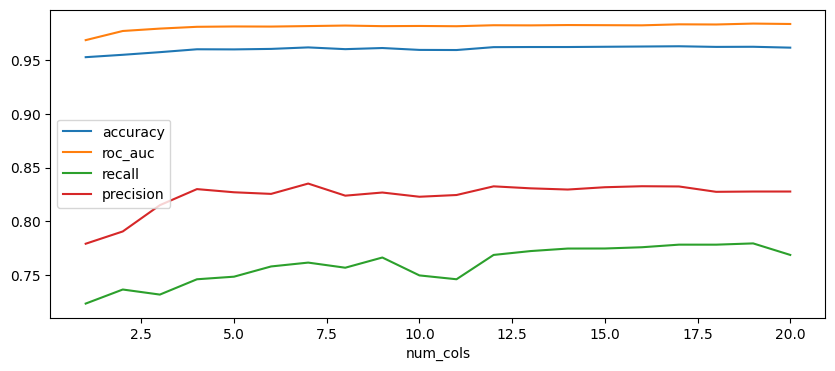

In [23]:
#Проходимся по всем фичам и смотрим, дает ли каждая из них прирост или наоборот портит
MODEL_COLUMNS = fe.head(20)['feature_names'].tolist()
d_score_res = plot_metric_by_feature(MODEL_COLUMNS, clf, 
                                     metrics_names=['accuracy','roc_auc','recall','precision'])

CPU times: user 4min 47s, sys: 2min 25s, total: 7min 12s
Wall time: 3min 50s


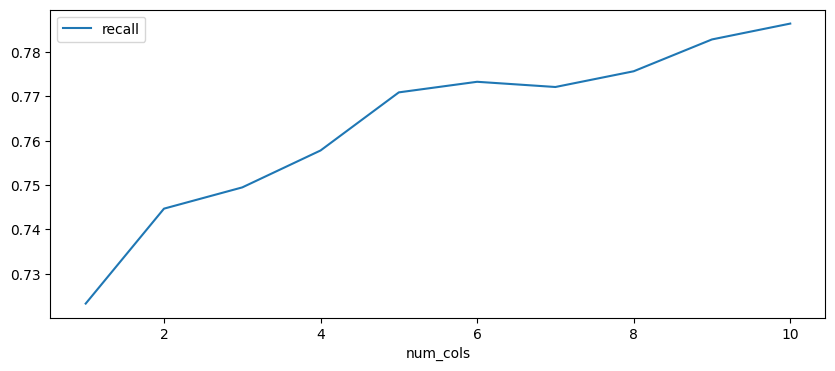

In [24]:
%%time
#из топ 20 фичей добавляем каждый раз ту, которая дает наибольший прирост по метрике
features = fe.head(20)['feature_names'].tolist()
test_metric_compare = 0

MODEL_COLUMNS = ['population_walking_5min']
for i in range(len(features)-11):
    metrics_compare = {}
    for feature in features:
        if feature not in MODEL_COLUMNS:
            MODEL_COLUMNS.append(feature)
            clf_baseline1, metric_accuracy, metric_roc_auc, \
                    metric_recall, metric_precision = run_model(clf, MODEL_COLUMNS, verbosity=False, print_plot=False)
            metrics_compare[feature] = metric_recall
            MODEL_COLUMNS.remove(feature)
            
    best_feature = max(metrics_compare, key=metrics_compare.get)
    MODEL_COLUMNS.append(best_feature)
    features.remove(best_feature)

d_score_res = plot_metric_by_feature(MODEL_COLUMNS, clf, 
                                     metrics_names=['recall'])

**Выбор параметров модели**

In [25]:
MODEL_COLUMNS

['population_walking_5min',
 'apteki_walking_5min',
 'stroitelnye_materialy_walking_10min',
 'platezhnye_terminaly_walking_5min',
 'detskie_sady_walking_10min',
 'lekarstvennye_preparaty_walking_5min',
 'cnt_evening',
 'mjagkaja_mebel_walking_10min',
 'supermarkety_walking_5min',
 'uslugi_po_uhodu_za_resnitsami__brovjami_walking_5min']

In [26]:
clf = CatBoostClassifier(
    iterations=200,
    depth=2,
    learning_rate=0.1,
    loss_function='CrossEntropy',
    random_state=RANDOM_STATE,
    verbose=False
)
clf_baseline1,_,_,_,_ = run_model(clf, MODEL_COLUMNS, print_plot=True)

test_accuracy metrics: 0.9637 ± 0.0029
test_roc_auc metrics: 0.9827 ± 0.0028
test_recall metrics: 0.7864 ± 0.0247
test_precision metrics: 0.8331 ± 0.0122


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
df_predicitions = df_X.reset_index()[[f'geo_h3_{RES}', 'target', 'cnt', 'desc']+MODEL_COLUMNS]
df_predicitions['predictions'] = clf_baseline1.predict_proba(df_X[MODEL_COLUMNS])[:, 1]
df_predicitions['predictions_binary'] = df_predicitions['predictions']\
                                            .apply(lambda x: 1 if x > 0.5 else 0)

In [28]:
df_predicitions['bins'] = pd.cut(df_predicitions['predictions'], 7)
df_predicitions.groupby('bins').agg({'predictions': 'mean', 'target': 'mean'})

,predictions,target
bins,,
"(-0.000253, 0.143]",0.009993,0.035816
"(0.143, 0.286]",0.208623,0.498715
"(0.286, 0.428]",0.356074,0.612903
"(0.428, 0.571]",0.499754,0.755034
"(0.571, 0.713]",0.644736,0.851266
"(0.713, 0.856]",0.785285,0.923567
"(0.856, 0.998]",0.948910,0.987122


pickle.dump(clf_baseline1, open('../src/postamat_cb_model.sav', 'wb'))

In [29]:
# предсказания на весь город
df_pred_all = df_piv.reset_index()[[f'geo_h3_{RES}']+MODEL_COLUMNS]
df_pred_all['predictions'] = clf_baseline1.predict_proba(df_piv[MODEL_COLUMNS])[:, 1]
df_pred_all['model_type'] = 'Бинарная модель с учётом проходимости'
df_pred_all['predictions'] = df_pred_all['predictions'].astype(float)

df_pred_all.to_sql(schema=SCHEMA, name = 'model_msk_predictions', con=engine, if_exists='replace', index=None)

In [30]:
df_postamats['icon'] = 'place'

In [31]:
#Выбр хексагон, в которых стоят постаматы, которы плохо предсказываются
df_postamats_pred = df_postamats.merge(
    df_predicitions[['geo_h3_10', 'target', 'predictions']], on='geo_h3_10'
)
df_postamats_pred['predictions_binary'] = df_postamats_pred['predictions']\
                                            .apply(lambda x: 1 if x > 0.5 else 0)

<AxesSubplot: >

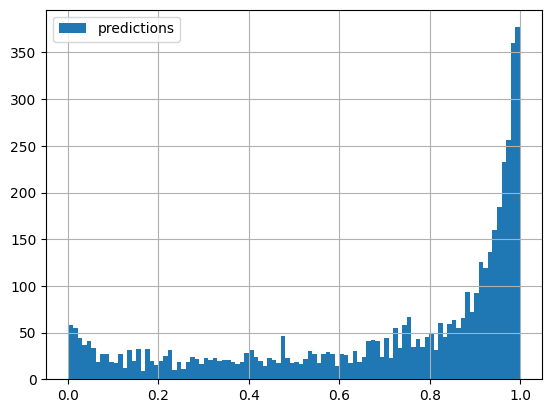

In [32]:
df_postamats_pred['predictions'].hist(bins=100, legend = True)

In [ ]:
#расчет скора на постаматы каждой компании в отдельности
d_score_by_company = {'company':[],'sum_target':[], 'sum_predictions':[], 
                      'cnt_target':[], 'score':[]}

for company in df_postamats['company'].drop_duplicates().tolist():
    filtered_df = df_postamats_pred[df_postamats_pred['company']==company].reset_index(drop=True).copy()
    
    d_score_by_company['sum_target'].append(filtered_df['target'].sum())
    d_score_by_company['sum_predictions'].append(filtered_df['predictions_binary'].sum())
    d_score_by_company['cnt_target'].append(filtered_df['target'].count())

    d_score_by_company['company'].append(company)
    d_score_by_company['score'].append(recall_score(filtered_df['target'], filtered_df['predictions_binary']))

df_score_by_company = pd.DataFrame(d_score_by_company).sort_values(by='score', ascending=False)
# df_score_by_company

In [34]:
#хексагоны, в которых стоят постаматы редких компаний
bad_hex_with_postamat = df_postamats_pred[df_postamats_pred['company'].isin(
            df_score_by_company[df_score_by_company['cnt_target']<25]['company'].tolist())]['geo_h3_10']\
    .drop_duplicates().tolist()

**Шапаш**

In [113]:
xpl = SmartExplainer(
  model=clf_baseline1,
)

In [114]:
xpl.compile(
    x=df_predicitions[MODEL_COLUMNS],    
    y_pred=df_predicitions['predictions_binary'], # Optional: for your own prediction (by default: model.predict)
    y_target=df_predicitions['target'], # Optional: allows to display True Values vs Predicted Values
)

app = xpl.run_app()

In [34]:
map_cfg = '../rnd_data/model_map_cfg'
cfg = gt.load_pickle(map_cfg)

In [159]:
map_ = KeplerGl(config = cfg, height=800)
# map_.add_data(df_pred_all, 'data')
map_.add_data(df_postamats, 'postamats')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': 'k4pgk9xnm', …

In [29]:
gt.save_pickle(map_.config, map_cfg)

In [34]:
# df_pred_all.to_sql(schema=SCHEMA, name = 'platform_model', con=engine, if_exists='replace', index=None)

### Маска канибализации

In [56]:
df_postamats_unique = df_postamats.drop_duplicates(subset = f'geo_h3_{RES}')[['point_lat', 'point_lon']]
df_postamats_unique['join'] = 1
df_domain = gt.geo_lat_lon_from_h3(df_domain, f'geo_h3_{RES}')
df_domain_ll = df_domain[['lat', 'lon']].copy()
df_domain_ll['join'] = 1
df_mask = pd.merge(df_domain_ll, df_postamats_unique, on = 'join')

In [58]:
df_mask['dist'] = gt.haversine_np(
    df_mask['lat'], df_mask['lon'], df_mask['point_lat'], df_mask['point_lon'])

In [59]:
df_mask = df_mask[df_mask['dist'] < 10]
df_mask[f'geo_h3_{RES}'] = gt.make_h3_index(df_mask, 'lat', 'lon', RES)

In [60]:
df_mask = df_mask.sort_values(by = [f'geo_h3_{RES}', 'dist'])
df_mask_f = df_mask.drop_duplicates(subset = f'geo_h3_{RES}')[[f'geo_h3_{RES}', 'dist']]

In [61]:
df_mask_f.to_sql(schema=SCHEMA, name = 'platform_can_mask', con=engine, if_exists='replace', index=None)

612

In [62]:
df_merge = pd.merge(df_pred_all, df_mask_f, on = f'geo_h3_{RES}')
df_merge['predictions'] = df_merge['predictions'] * df_merge['dist']

df_merge = df_merge.drop(['dist'], axis = 1)
df_merge['model_type'] = 'Бинарная модель с учётом конкурентов'
scaler = MinMaxScaler()
df_merge['predictions'] = scaler.fit_transform(df_merge['predictions'].values.reshape(-1,1))


In [128]:
df_merge.to_sql(schema=SCHEMA, name = 'platform_model', con=engine, if_exists='append', index=None)

In [ ]:
map_2 = create_Kepler_map()
map_2.add_data(df_merge, 'data')
map_2

#### бесполезное

In [428]:
df_comanies = pd.read_csv("../data/popular_rubrics.csv", sep = ';')

In [429]:
df_first = df_comanies[df_comanies['rubric'].isin(['МФЦ', 'Библиотеки', 'Киоски / магазины по продаже печатной продукции'])]

In [437]:
df_first

,city,rubric,name,id,address_building_id,address_name,address_components_0_street_id,point_lat,point_lon,geo_h3_10
223769,Москва,Киоски / магазины по продаже печатной продукции,Киоск по продаже печатной продукции,70000001063172855,4.504235e+15,"Чертановская улица, 23а киоск",4.504338e+15,55.619485,37.594221,8a11aa7964d7fff
223770,Москва,Киоски / магазины по продаже печатной продукции,Киоск печатной продукции,70000001051366500,4.504235e+15,"Таганская улица, 17-23 киоск",4.504338e+15,55.739881,37.664718,8a11aa7889b7fff
223771,Москва,Киоски / магазины по продаже печатной продукции,"Антарес, киоск печатной продукции",70000001056366106,4.504235e+15,"Шаболовка, 69/32 киоск",4.504338e+15,55.712127,37.607468,8a11aa780ad7fff
223772,Москва,Киоски / магазины по продаже печатной продукции,"Антарес, киоск печатной продукции",70000001035127032,4.504235e+15,"улица Ботаническая, 29 к1 киоск",4.504338e+15,55.833503,37.594910,8a11aa719d17fff
223773,Москва,Киоски / магазины по продаже печатной продукции,"Краснопресненское агентство печати, киоск печа...",70000001020380697,4.504235e+15,"улица Хачатуряна, вл15Б киоск",4.504338e+15,55.862610,37.603798,8a11aa70a3a7fff
...,...,...,...,...,...,...,...,...,...,...
286554,Москва,МФЦ,"Мои документы, центр предоставления государств...",70000001035526710,4.504235e+15,"Шама, 9",4.504338e+15,55.634398,37.849618,8a11aa690817fff
286555,Москва,МФЦ,"Мои документы, центр государственных услуг",70000001020297229,4.504235e+15,"Школьная, 5",4.504338e+15,55.661034,37.983219,8a11aa69b727fff
286556,Москва,МФЦ,"Мои документы, центр государственных услуг",70000001040612623,4.504235e+15,"деревня Брёхово, ст83м",NaN,55.929326,37.194138,8a11aa0134a7fff
286557,Москва,МФЦ,"Мои документы, Паспортный стол",70000001029074362,4.504235e+15,"Академика Жукова, 40",4.504338e+15,55.625136,37.837482,8a11aa696b5ffff


In [430]:
df_pred_all = df_piv.reset_index()[[f'geo_h3_{RES}']]
df_pred_all['predictions'] = clf_baseline1.predict_proba(df_piv[MODEL_COLUMNS])[:, 1]

In [431]:
df_pred_all['first'] = 0
df_pred_all.loc[df_pred_all['geo_h3_10'].isin(df_first['geo_h3_10']), 'first'] = 1
df_pred_all['bins'] = pd.cut(df_pred_all['predictions'], 7)

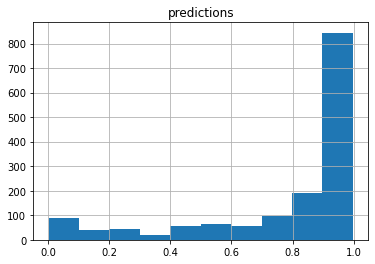

In [432]:
df_pred_all[df_pred_all['first'] == 1][['predictions']].hist();

In [433]:
df_pred_all.groupby('bins').agg({'predictions': 'mean', 'first': 'mean'})

,predictions,first
bins,,
"(-0.000412, 0.143]",0.016475,0.003312
"(0.143, 0.286]",0.208823,0.017617
"(0.286, 0.428]",0.355553,0.017309
"(0.428, 0.57]",0.501352,0.032221
"(0.57, 0.713]",0.643882,0.032168
"(0.713, 0.855]",0.792058,0.041141
"(0.855, 0.998]",0.943576,0.069464


In [393]:
map_ = create_Kepler_map()
map_.add_data(df_predicitions.drop('bins', axis = 1), 'train')
map_.add_data(df_pred_all, 'data')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [], 'interactionConfig': {'…

### For presentation

#### Корелляция

In [111]:
corr_columns = list(MODEL_COLUMNS).copy()
corr_columns.append('postamaty_walking_10min')
# corr_columns.remove('razrabotka_programmnogo_obespechenija_walking_15min')
# corr_columns.remove('remont_hodovoj_chasti_avtomobilja_walking_10min')
# corr_columns.remove('avtoremont_i_tehobsluzhivanie_sto_walking_5min')
# corr_columns.remove('stroitelnye_materialy_walking_15min')
# corr_columns.remove('stroitelnye_materialy_walking_5min')

In [112]:
corr_columns

['population_walking_5min',
 'apteki_walking_5min',
 'stroitelnye_materialy_walking_10min',
 'platezhnye_terminaly_walking_5min',
 'detskie_sady_walking_10min',
 'lekarstvennye_preparaty_walking_5min',
 'cnt_evening',
 'mjagkaja_mebel_walking_10min',
 'supermarkety_walking_5min',
 'uslugi_po_uhodu_za_resnitsami__brovjami_walking_5min',
 'postamaty_walking_10min']

/var/folders/3q/9304t9dj6yb6rxcr24slkv500000gn/T/ipykernel_26821/60045040.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


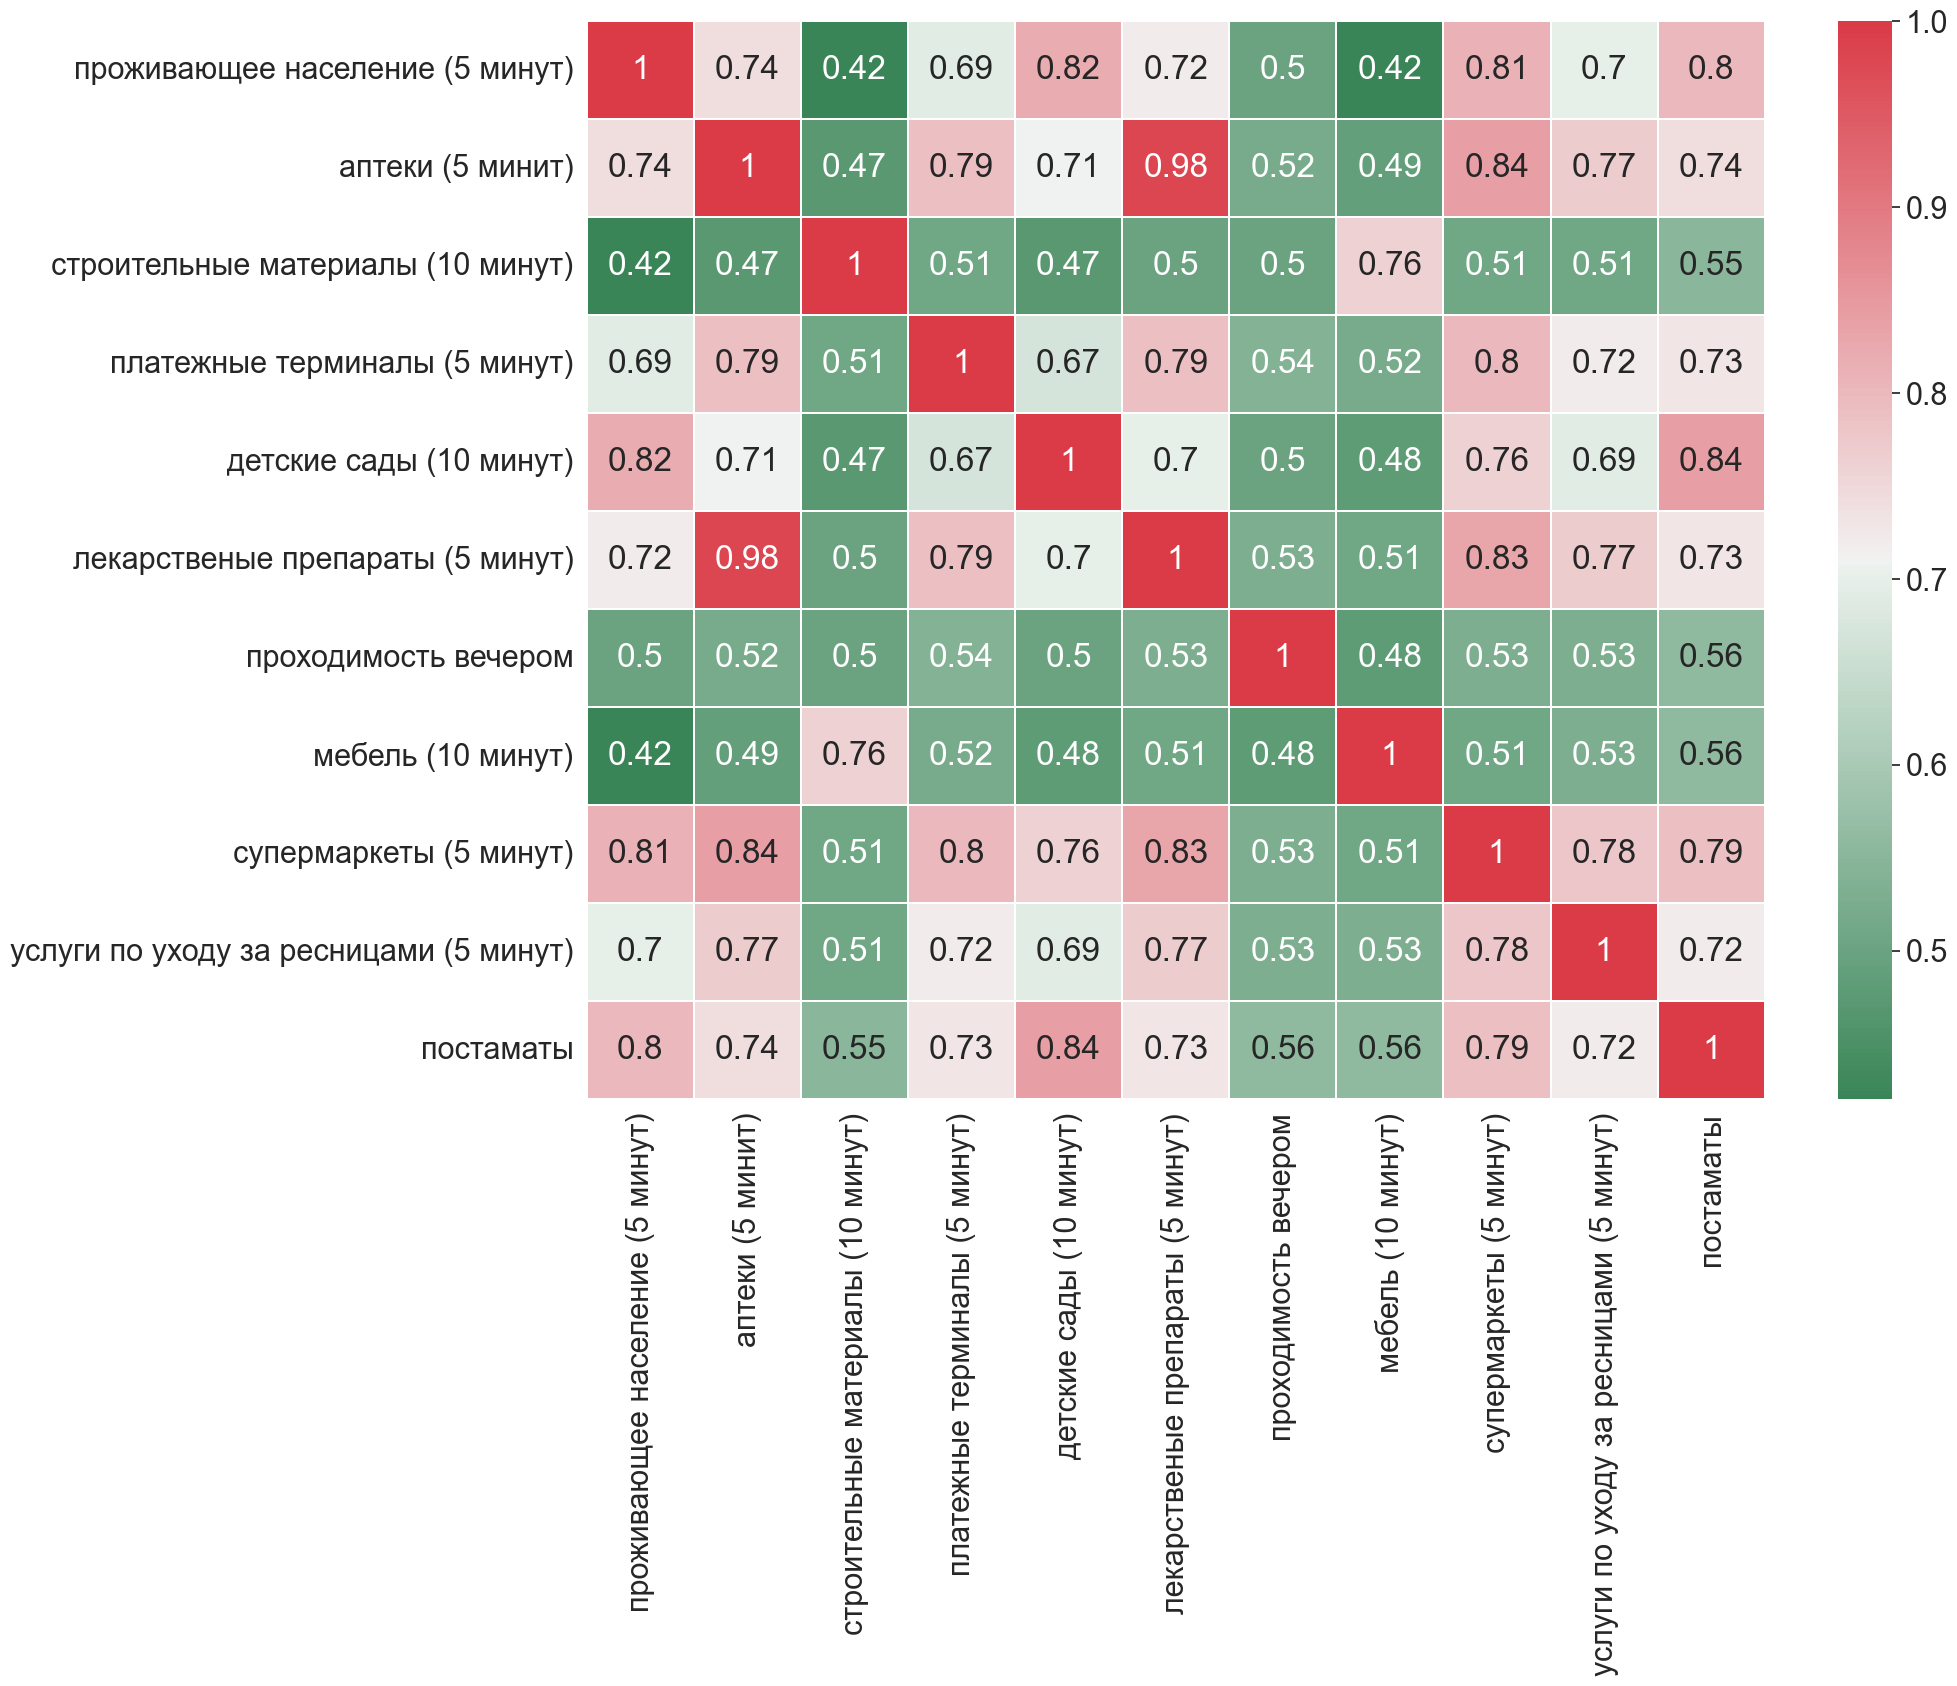

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(19,14))    
# label to make it neater
labels = {
     'population_walking_5min': 'проживающее население (5 минут)',
     'apteki_walking_5min': 'аптеки (5 минит)',
     'stroitelnye_materialy_walking_10min': 'строительные материалы (10 минут)',
     'platezhnye_terminaly_walking_5min': 'платежные терминалы (5 минут)',
     'detskie_sady_walking_10min': 'детские сады (10 минут)',
     'lekarstvennye_preparaty_walking_5min': 'лекарственые препараты (5 минут)',
     'cnt_evening': 'проходимость вечером',
     'mjagkaja_mebel_walking_10min': 'мебель (10 минут)',
     'supermarkety_walking_5min': 'супермаркеты (5 минут)',
     'uslugi_po_uhodu_za_resnitsami__brovjami_walking_5min': 'услуги по уходу за ресницами (5 минут)',
     'postamaty_walking_10min': 'постаматы'
}
corr = df_piv[corr_columns].corr(method='spearman')
corr = corr.rename(labels)
corr.columns = [labels[x] for x in corr.columns]
corr = corr.round(2)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if you want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
sns.set(font_scale=2)
ans=sns.heatmap(corr,  linewidths=.3, cmap=cmap, annot=True, ax=ax)
# plt.setp(ans.get_xticklabels(), rotation=45)

# #save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Как собираются фичи

In [250]:
from shapely import wkb

In [297]:
df_isochrones = pd.read_sql(f"""select * from {SCHEMA}.platform_isochrones
            where 1=1
                and geo_h3_10 in ('8a11aa7932affff'
                --, '8a11aa7930d7fff'
                )
                 """, engine)

df_isochrones['geometry'] = df_isochrones['geometry'].apply(lambda x: wkb.loads(x, hex=True))
gdf_shape = gpd.GeoDataFrame(df_isochrones, geometry = 'geometry')
gdf_shape = gdf_shape.h3.polyfill_resample(RES).reset_index()
df_isochrones['geometry'] = df_isochrones['geometry'].astype(str)
df_isochrones['order'] = df_isochrones['kind'].map({'walking_15min': 1, 'walking_10min': 2, 'walking_5min': 3})
df_isochrones = gt.geo_lat_lon_from_h3(df_isochrones, f'geo_h3_{RES}')
df_isochrones

,geo_h3_10,kind,geometry,order,lat,lon
0,8a11aa7932affff,walking_5min,"POLYGON ((37.658347 55.651272, 37.656898 55.65...",3,55.648108,37.658347
1,8a11aa7932affff,walking_10min,"POLYGON ((37.662347 55.652207, 37.661347 55.65...",2,55.648108,37.658347
2,8a11aa7932affff,walking_15min,"POLYGON ((37.665347 55.655493, 37.663491 55.65...",1,55.648108,37.658347


In [353]:
s = "','".join(list(gdf_shape['h3_polyfill'].unique()))
s = f"'{s}'"
df_buildings = pd.read_sql(
    f"""select * from {SCHEMA}.platform_buildings where geo_h3_{RES} in ({s})""", engine)
df_buildings['geometry'] = df_buildings['geometry'].apply(
    lambda x: wkb.loads(x, hex=True))
df_buildings['geometry'] = df_buildings['geometry'].astype(str)
df_buildings = df_buildings.drop(
    ['geometry_centroid', 'structure_info_material', 'lat', 'lon', 'id', 'name', 'address_name'], axis=1)
df_buildings['floors_ground_count'].fillna(1, inplace=True)

df_buildings['good'] = 0
df_buildings.loc[df_buildings['purpose_name'].isin(['Жилой дом', 'Киоск']), 'good'] = 1

In [354]:
df_buildings.head()

,floors_ground_count,geometry,purpose_name,structure_info_apartments_count,geo_h3_10,good
0,5.0,"POLYGON ((37.660823 55.6461, 37.661527 55.6458...",Жилой дом,60.0,8a1181b6d937fff,1
1,20.0,"POLYGON ((37.659006 55.644788, 37.659046 55.64...",Жилой дом,388.0,8a11aa793667fff,1
2,17.0,"POLYGON ((37.664333 55.641472, 37.664256 55.64...",Жилой дом,405.0,8a11aa7936cffff,1
3,5.0,"POLYGON ((37.665491 55.647606, 37.666432 55.64...",Жилой дом,70.0,8a1181b6d90ffff,1
4,5.0,"POLYGON ((37.662027 55.647375, 37.66266 55.647...",Жилой дом,55.0,8a1181b6d927fff,1


In [384]:
df_companies = pd.read_sql(
    f"""select * from {SCHEMA}.platform_companies where geo_h3_{RES} in ({s})""", engine)
df_companies['geometry'] = df_companies['geometry'].apply(
    lambda x: wkb.loads(x, hex=True))

In [378]:
good_rubrics = list(df_companies['rubric'].value_counts().head(20).index)
good_rubrics.remove('Вывоз мусора')
df_companies = df_companies[df_companies['rubric'].isin(good_rubrics)]
df_companies['geometry'] = df_companies['geometry'].astype(str)
df_companies = df_companies.drop(
    ['id', 'address_building_id', 'rubrics_0_name'], axis=1)

In [401]:
df_layer = pd.read_sql(
    f"""select * from {SCHEMA}.platform_model where geo_h3_{RES} in ({s}) """, engine)

In [402]:
df_layer_1 = df_layer[df_layer['model_type'] == 'Бинарная модель']
df_layer_2 = df_layer[df_layer['model_type'] == 'Бинарная модель с учётом конкурентов']

In [403]:
df_postamats = df_companies[df_companies['rubric'] == 'Постаматы'].copy()
df_postamats['icon'] = 'place'

In [404]:
df_buildings_opt = pd.merge(df_buildings, df_layer, on = 'geo_h3_10')
df_buildings_opt = df_buildings_opt[(
    df_buildings_opt['structure_info_apartments_count'] > 10) | (df_buildings_opt['purpose_name'] =='Киоск')]

In [405]:
df_model_layers = pd.read_sql(
    f""" select geo_h3_{RES}, population, supermarkety
    from {SCHEMA}.platform_features where geo_h3_{RES} in ({s}) and kind='walking_10min'""", engine)

In [408]:
map_pres = create_Kepler_map(config_path='map_pres_cfg')
map_pres.add_data(df_isochrones.sort_values(by = 'order'), 'isochrones')
map_pres.add_data(df_buildings, 'buildings')
map_pres.add_data(df_buildings_opt, 'buildings_opt')
map_pres.add_data(df_model_layers, 'model_features')
map_pres.add_data(df_companies.drop('geometry', axis = 1), 'companies')
map_pres.add_data(df_postamats.drop('geometry', axis = 1), 'postamats')
map_pres.add_data(df_layer_1, 'model1')
map_pres.add_data(df_layer_2, 'model2')
map_pres

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['buildings_opt'], 'id': 'z4h…

In [411]:
gt.save_pickle(map_pres.config, 'map_pres_cfg')

In [412]:
map_pres.save_to_html(data={'buildings': df_buildings, "isochrones": df_isochrones, 'model_features': df_model_layers,
                            "buildings_opt": df_buildings_opt, 'companies': df_companies.drop('geometry', axis = 1),
                            'postamats': df_postamats.drop('geometry', axis = 1), 'model1': df_layer_1, 'model2': df_layer_2}, 
                      config=map_pres.config)

Map saved to keplergl_map.html!
